# **Detecting Skin Cancer with Deep Learning**

Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Unzipping HAM10000 dataset from google drive

In [ ]:
!unzip '/content/drive/My Drive/AI Dataset/HAM10000.zip'  -d '/content/'

Importing libraries

In [ ]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# for GPU on G. Colab
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Importing the dataset

In [ ]:
skin_dataset = pd.read_csv('HAM10000_metadata.csv')


In [ ]:
skin_dataset.head() # returns the first n rows for the object based on position
# dx: diagnosis for patient
# dx_type: how the diagnosis was made


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
skin_dataset.dtypes # return data type of each column

lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dtype: object

In [ ]:
skin_dataset['image_name'] = skin_dataset['image_id'] + '.jpg'
subset1 = skin_dataset[['lesion_id', 'dx', 'image_name']]
subset1.head()

,lesion_id,dx,image_name
0,HAM_0000118,bkl,ISIC_0027419.jpg
1,HAM_0000118,bkl,ISIC_0025030.jpg
2,HAM_0002730,bkl,ISIC_0026769.jpg
3,HAM_0002730,bkl,ISIC_0025661.jpg
4,HAM_0001466,bkl,ISIC_0031633.jpg


In [ ]:
subset2 = subset1.pop('dx').to_frame()
subset2.head()


,dx
0,bkl
1,bkl
2,bkl
3,bkl
4,bkl


In [ ]:
from pathlib import Path
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(subset1, subset2, test_size=0.25, random_state=100, stratify=subset2) 
  # test size 25% and train 75%
  # stratification which will lock the distribution of classes in train and test sets. help prevent imbalance test sets
    # making sure to have a balance set of dx for test and train


"""
train_path = Path('/content/', 'train.csv')
test_path = Path('/content/', 'test.csv')
train.to_csv(train_path, sep='\t', index=False)
test.to_csv(test_path, sep='\t', index=False)
"""

print("Train: ", x_train)
print("Train: ", x_test)

print("Test: ", y_train)
print("Test: ", y_test)


Train:          lesion_id        image_name
1077  HAM_0005096  ISIC_0029741.jpg
357   HAM_0003089  ISIC_0030706.jpg
761   HAM_0001763  ISIC_0029029.jpg
1234  HAM_0003182  ISIC_0029028.jpg
1441  HAM_0005328  ISIC_0032441.jpg
...           ...               ...
7724  HAM_0001645  ISIC_0032878.jpg
4351  HAM_0001885  ISIC_0027534.jpg
9434  HAM_0001916  ISIC_0032721.jpg
3011  HAM_0001180  ISIC_0029303.jpg
9653  HAM_0001393  ISIC_0027418.jpg

[7511 rows x 2 columns]
Train:          lesion_id        image_name
9957  HAM_0006587  ISIC_0025780.jpg
241   HAM_0007341  ISIC_0032898.jpg
8422  HAM_0005261  ISIC_0027390.jpg
5183  HAM_0001451  ISIC_0029960.jpg
7814  HAM_0007169  ISIC_0033433.jpg
...           ...               ...
8275  HAM_0000509  ISIC_0024837.jpg
36    HAM_0000351  ISIC_0029559.jpg
5543  HAM_0001980  ISIC_0032012.jpg
3287  HAM_0004177  ISIC_0031907.jpg
82    HAM_0001773  ISIC_0024832.jpg

[2504 rows x 2 columns]
Test:         dx
1077  bkl
357   bkl
761   bkl
1234  mel
1441  mel
...

In [ ]:
train_set = pd.concat([x_train, y_train], axis = 1)
test_set = pd.concat([x_test, y_test], axis = 1)
print(train_set)
print(test_set)

        lesion_id        image_name   dx
1077  HAM_0005096  ISIC_0029741.jpg  bkl
357   HAM_0003089  ISIC_0030706.jpg  bkl
761   HAM_0001763  ISIC_0029029.jpg  bkl
1234  HAM_0003182  ISIC_0029028.jpg  mel
1441  HAM_0005328  ISIC_0032441.jpg  mel
...           ...               ...  ...
7724  HAM_0001645  ISIC_0032878.jpg   nv
4351  HAM_0001885  ISIC_0027534.jpg   nv
9434  HAM_0001916  ISIC_0032721.jpg   nv
3011  HAM_0001180  ISIC_0029303.jpg   nv
9653  HAM_0001393  ISIC_0027418.jpg   nv

[7511 rows x 3 columns]
        lesion_id        image_name     dx
9957  HAM_0006587  ISIC_0025780.jpg  akiec
241   HAM_0007341  ISIC_0032898.jpg    bkl
8422  HAM_0005261  ISIC_0027390.jpg     nv
5183  HAM_0001451  ISIC_0029960.jpg     nv
7814  HAM_0007169  ISIC_0033433.jpg     nv
...           ...               ...    ...
8275  HAM_0000509  ISIC_0024837.jpg     nv
36    HAM_0000351  ISIC_0029559.jpg    bkl
5543  HAM_0001980  ISIC_0032012.jpg     nv
3287  HAM_0004177  ISIC_0031907.jpg     nv
82    HAM_

In [ ]:
from sklearn.preprocessing import LabelEncoder
# to convert categorical text data to model-understandable numerical data

le = LabelEncoder()
le.fit(test_set['dx'])
index = le.transform(test_set['dx'])
test_set['label encoder'] = index

print(test_set)


        lesion_id        image_name     dx  label encoder
9957  HAM_0006587  ISIC_0025780.jpg  akiec              0
241   HAM_0007341  ISIC_0032898.jpg    bkl              2
8422  HAM_0005261  ISIC_0027390.jpg     nv              5
5183  HAM_0001451  ISIC_0029960.jpg     nv              5
7814  HAM_0007169  ISIC_0033433.jpg     nv              5
...           ...               ...    ...            ...
8275  HAM_0000509  ISIC_0024837.jpg     nv              5
36    HAM_0000351  ISIC_0029559.jpg    bkl              2
5543  HAM_0001980  ISIC_0032012.jpg     nv              5
3287  HAM_0004177  ISIC_0031907.jpg     nv              5
82    HAM_0001773  ISIC_0024832.jpg    bkl              2

[2504 rows x 4 columns]


Building the CNN

In [ ]:
classifier = Sequential() # initializing
classifier.add(Convolution2D(32, kernel_size = (3, 3), input_shape = (64, 64, 3), activation = 'relu')) # build conv. layer
classifier.add(MaxPooling2D(pool_size = (2, 2))) # pool layer

# second conv. layer
classifier.add(Convolution2D(32, kernel_size = (3, 3), activation = 'relu')) # second conv. layer
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.1))


# adding another layer
classifier.add(Convolution2D(64, kernel_size = (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size = (2,2)))
classifier.add(Convolution2D(128, kernel_size = (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size = (2,2)))
classifier.add(Dropout(0.2))



classifier.add(Flatten()) # converting the data into a 1-dimensional array for inputting it to the next layer.

# fully connected layer
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dropout(0.4))
classifier.add(Dense(units = 1, activation = 'sigmoid'))
classifier.add(Dense(7, activation='softmax'))  # number of classes = 7

# compilng CNN
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
classifier.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.2, min_lr=0.00001)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=12)
checkpoint = ModelCheckpoint('/content/best.hdf5', verbose=1,save_best_only=True)
    
classifier.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0

Fitting CNN to Images

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
b_size = 32
train_gen = ImageDataGenerator(rescale = 1./255, shear_range = 0.1, zoom_range = 0.1, width_shift_range=0.1, height_shift_range=0.1, rotation_range=10, horizontal_flip = True, vertical_flip = True)


train_data = train_gen.flow_from_dataframe(dataframe = train_set, x_col = 'image_name', y_col = 'dx', directory='HAM10000', target_size=(64, 64), batch_size = b_size, class_mode='categorical')

test_gen = ImageDataGenerator(rescale = 1./255) # only rescaling. 
test_data = test_gen.flow_from_dataframe(dataframe = test_set, x_col = 'image_name', y_col = 'dx', directory='HAM10000', target_size=(64, 64), batch_size = b_size, class_mode='categorical')

graph = classifier.fit(train_data, steps_per_epoch=(6000//train_data.batch_size), epochs=25, validation_data=test_data, validation_steps=(1500/test_data.batch_size), callbacks=[lr_reduction, early_stop, checkpoint])

Found 7511 validated image filenames belonging to 7 classes.
Found 2504 validated image filenames belonging to 7 classes.
Epoch 1/25
187/187 [==============================] - ETA: 0s - loss: 1.2392 - accuracy: 0.6204
Epoch 00001: val_loss improved from inf to 1.14838, saving model to /content/best.hdf5
187/187 [==============================] - 77s 409ms/step - loss: 1.2392 - accuracy: 0.6204 - val_loss: 1.1484 - val_accuracy: 0.6609 - lr: 0.0100
Epoch 2/25
187/187 [==============================] - ETA: 0s - loss: 1.1282 - accuracy: 0.6695
Epoch 00002: val_loss improved from 1.14838 to 1.13049, saving model to /content/best.hdf5
187/187 [==============================] - 72s 387ms/step - loss: 1.1282 - accuracy: 0.6695 - val_loss: 1.1305 - val_accuracy: 0.6689 - lr: 0.0100
Epoch 3/25
187/187 [==============================] - ETA: 0s - loss: 1.1334 - accuracy: 0.6696
Epoch 00003: val_loss improved from 1.13049 to 1.10001, saving model to /content/best.hdf5
187/187 [==================

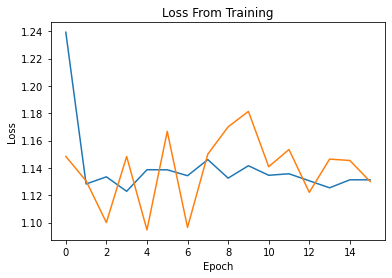

In [ ]:
import matplotlib.pyplot as plt 
fig1 = plt.figure()
plt.plot(graph.history['loss'])
plt.plot(graph.history['val_loss'])
plt.title('Loss From Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
fig1.savefig('/content/loss.png')

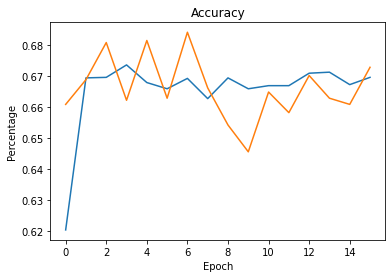

In [ ]:
fig2 = plt.figure()
plt.plot(graph.history['accuracy'])
plt.plot(graph.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Percentage')
plt.show()
fig2.savefig('/content/accuracy.png')